# Where could you build ADUs in Waltham before the rezoning?


In [40]:
import pandas as pd
import geopandas as geo_pd

from data.connect_db import get_db
from waltham.constants import SQ_FT_PER_ACRE

con = get_db()

In [41]:
# get data used below
query = "select * from \"M308Assess_CY23_FY24\""
tax_df = pd.read_sql(query, con)
tax_df = tax_df[[
    "PROP_ID",
    "LOC_ID",
    "LOT_SIZE",
    "USE_CODE",
    "SITE_ADDR",
    "YEAR_BUILT"
    
]]

query = "select * from \"M308TaxPar_CY23_FY24\""
geo_df = geo_pd.read_postgis(query, con)
geo_df = geo_df[[
    "geom",
    "LOC_ID"
]]

# N.B. requires that the owner_occupied_homes notebook be
# ran first
owners_df = pd.read_csv("likely_homeowners.csv")
owners_df = owners_df[["PROP_ID", "OWNER_OCCUPIED"]]

query = "select * from \"WalthamZoning\""
zones_df = geo_pd.read_postgis(query, con)
zones_df = zones_df[[
    "geom",
    "NAME"
]]

In [42]:
# merge/geometric join, and cleanup

df = tax_df.merge(owners_df, on="PROP_ID")

geo_df = geo_df.sjoin(zones_df)
geo_df.drop(columns="index_right", inplace=True)

df = geo_df.merge(df, on="LOC_ID")

# value here is in acres, code uses square feet
df["LOT_SIZE"] = df["LOT_SIZE"].apply(lambda x: x * SQ_FT_PER_ACRE)

# just put in an old date where buildings have no recorded date
df["YEAR_BUILT"] = df["YEAR_BUILT"].apply(lambda x: max(x, 1800))
df

,geom,LOC_ID,NAME,PROP_ID,LOT_SIZE,USE_CODE,SITE_ADDR,YEAR_BUILT,OWNER_OCCUPIED
0,"MULTIPOLYGON (((219510.406 900516.563, 219505....",F_720118_2954451,RA3,R079 001 0038,6534.0,101,759 SOUTH ST,1975,True
1,"MULTIPOLYGON (((219521.229 900544.743, 219512....",F_720144_2954524,RA3,R079 001 0036,9583.2,104,753-55 SOUTH ST,1860,False
2,"MULTIPOLYGON (((220212.276 900527.633, 220199....",F_722474_2954539,RA3,R080 002 0014,4791.6,132,72 LOT EDGEWATER DR,1800,True
3,"MULTIPOLYGON (((220212.276 900527.633, 220199....",F_722474_2954539,CR,R080 002 0014,4791.6,132,72 LOT EDGEWATER DR,1800,True
4,"MULTIPOLYGON (((219481.807 900560.359, 219483....",F_720055_2954540,RA3,R079 001 0037,15246.0,101,757 SOUTH ST,1975,True
...,...,...,...,...,...,...,...,...,...
21616,"MULTIPOLYGON (((220926.94 904031.378, 220927.0...",F_724750_2965980,RA4,R041 019 0011,7840.8,131,32 BRADFORD ST,1800,False
21617,"MULTIPOLYGON (((220719.387 905318.045, 220707....",F_724149_2970270,RA3,R032 002 0004,5227.2,101,42 GREGORY ST,2023,True
21618,"MULTIPOLYGON (((219621.618 900818.126, 219621....",F_720384_2955443,RA3,R079 001 0012,9583.2,101,11 IRENE CIR,1890,True
21619,"MULTIPOLYGON (((219577.073 900752.583, 219573....",F_720425_2955290,RA3,R079 001 0013,9583.2,101,679 SOUTH ST,1900,True


In [43]:
df.columns

Index(['geom', 'LOC_ID', 'NAME', 'PROP_ID', 'LOT_SIZE', 'USE_CODE',
       'SITE_ADDR', 'YEAR_BUILT', 'OWNER_OCCUPIED'],
      dtype='object')

In [45]:
# get and pre-process buildings data
query = "select * from \"structures_poly_308\""
buildings_df = geo_pd.read_postgis(query, con)
buildings_df = buildings_df[["geom", "SHAPE_AREA", "STRUCT_ID"]]

# get the largest building on each parcel
buildings_df["bldg_geom"] = buildings_df["geom"]
buildings_df["geom"] = buildings_df.centroid

# TODO:
# should have the same number of buildings after this
before = len(buildings_df)
principal_bldgs_df = geo_df.sjoin(buildings_df, how="right", predicate="contains")

# we want the largest building on a parcel, so we'll sort by LOC_ID, and then built out area descending
principal_bldgs_df.sort_values(by=["LOC_ID", "SHAPE_AREA"], ascending=[True, False], inplace=True)
principal_bldgs_df.dropna(subset=["LOC_ID"], inplace=True)
principal_bldgs_df["IS_PRINCIPAL_BLDG"] = False

# group by loc id, and treat the largest structure as the principal building
for loc_id, group in principal_bldgs_df.groupby("LOC_ID"):
    principal_bldgs_df.at[group.index[0], "IS_PRINCIPAL_BLDG"] = True

principal_bldgs_df = principal_bldgs_df.set_geometry("bldg_geom").drop(columns="geom").rename_geometry("geom")
principal_bldgs_df.drop(columns="index_left", inplace=True)
principal_bldgs_df

,LOC_ID,NAME,SHAPE_AREA,STRUCT_ID,geom,IS_PRINCIPAL_BLDG
1414,F_714281_2972952,RA1,98.387448,217719_906158,"MULTIPOLYGON (((217726.764 906159.316, 217717....",True
8838,F_714362_2973054,RA1,192.125097,217739_906184,"MULTIPOLYGON (((217747.482 906187.504, 217739....",True
14997,F_714399_2973264,RA1,261.789006,217753_906267,"MULTIPOLYGON (((217745.747 906273.803, 217749....",True
12130,F_714449_2973138,RA1,161.987327,217770_906208,"MULTIPOLYGON (((217774.894 906216.88, 217780.2...",True
6134,F_714535_2973230,RA1,170.813389,217795_906236,"MULTIPOLYGON (((217798.952 906235.84, 217791.8...",True
...,...,...,...,...,...,...
416,F_738551_2965680,RA4,38.442696,225098_903942,"MULTIPOLYGON (((225102.021 903939.718, 225096....",False
11939,F_738563_2965602,RA4,126.121206,225120_903921,"MULTIPOLYGON (((225125.665 903927.394, 225126....",True
5632,F_738576_2965643,RA4,62.156583,225119_903931,"MULTIPOLYGON (((225120.142 903927.856, 225115....",True
11295,F_738666_2965735,RA4,119.636596,225144_903958,"MULTIPOLYGON (((225149.045 903956.388, 225149....",True


In [37]:
principal_bldgs_df.columns

Index(['LOC_ID', 'NAME', 'SHAPE_AREA', 'STRUCT_ID', 'geom',
       'IS_PRINCIPAL_BLDG'],
      dtype='object')

## The most optimistic case - any SFH plot can build an ADU

This isn't exactly practical for all plots (there is a minimum size of plot or ADU which would make construction unviable) but just as a quick check of the absolute maximum potential:

Text(0.5, 1.0, 'number of SFH homes in Waltham: 9529')

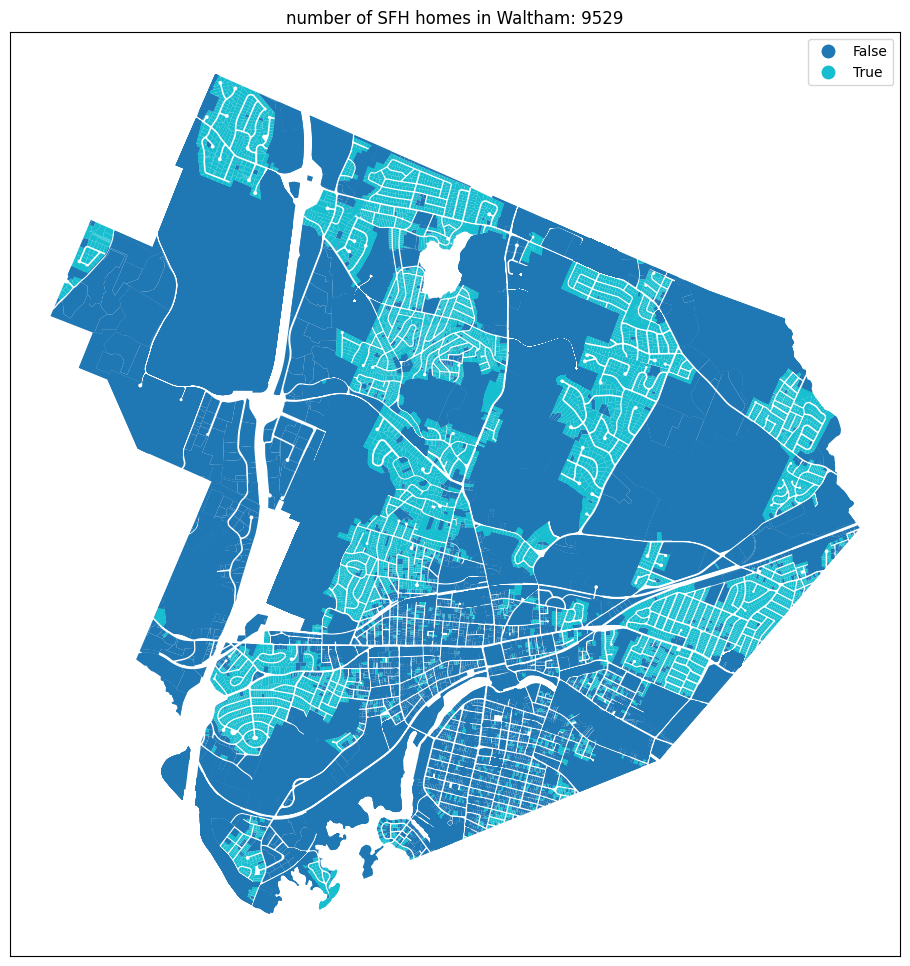

In [20]:
df["IS_SFH"] = df["USE_CODE"].apply(lambda x: x == "101")
ax = df.plot(column="IS_SFH", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

all_sfh_homes = len(df[df['IS_SFH']])

ax.set_title(f"number of SFH homes in Waltham: {all_sfh_homes}")

## Diving into the regulations

The section of our zoning code describing the regulations for ADUs can be found at the link below:

https://ecode360.com/13128595#13128572

Already in the first part of the first full sentence we're off to a bad start - the Board of Appeals must grant a special permit to allow an ADU. No way for there to be a by-right development by outlining
a clear set of rules and ministerial approval that the rules were followed to the letter. This is discouraging enough on its own.

Most of the regulations aren't really something that can be checked easily via GIS, so this analysis will just look at the criteria below.

## (b)

_The dwelling unit is accessory to the principal residence and either the dwelling unit or the principal residence is occupied by the owner of the lot on which the dwelling unit is to be located, which owner shall have owned the lot for not less than five years._

This is the kind of owner occupancy clause that the state law is specifically forbidding. It's just nonsense - why must the owner reside on the lot? And why a five year minimum residency requirement?

We don't have a foolproof way of checking residency, so we'll go with our current method of 'matching a lot of characters' in the owner address on the tax records matching the site address.

In [21]:
df["IS_OWNER_OCCUPIED_SFH"] = df.apply(lambda row: row["OWNER_OCCUPIED"] and row["IS_SFH"], axis=1)

Text(0.5, 1.0, 'owner occupied single family homes in Waltham (9008 / 9529)')

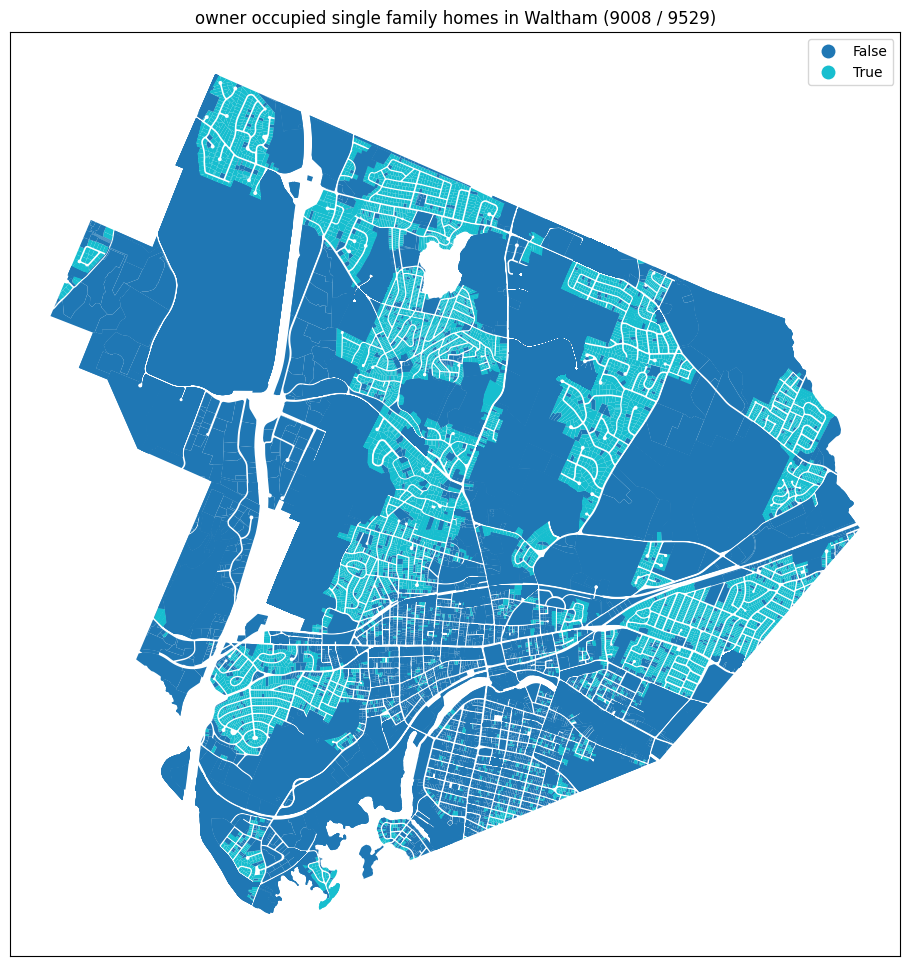

In [22]:
ax = df.plot(column="IS_OWNER_OCCUPIED_SFH", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

valid_sfh_homes = len(df[df['IS_OWNER_OCCUPIED_SFH']])

ax.set_title(f"owner occupied single family homes in Waltham ({valid_sfh_homes} / {all_sfh_homes})")

This doesn't seem to be a big blocker on its own, in Waltham at least. It gets worse though.

## (h)

_The lot on which the dwelling is located contains at least 20,000 square feet in Residence A-1 Districts and 15,000 square feet in Residence A-2 Districts._

This doesn't specify anything else about the other districts. Should we take this at its most restrictive interpretation, that ADUs are only allowed in A1 and A2?

In [23]:
def lot_conforms(row):
    zone = row["NAME"]
    if zone not in ["RA1", "RA2"] or not row["IS_OWNER_OCCUPIED_SFH"]:
        return False
    
    if zone == "RA1":
        return row["LOT_SIZE"] >= 20_000
    
    return row["LOT_SIZE"] >= 15_000


df["IS_LOT_SIZE_CONFORMING"] = df.apply(lambda row: lot_conforms(row), axis=1)

Text(0.5, 1.0, 'fraction of lot size conforming homes: 9.62%')

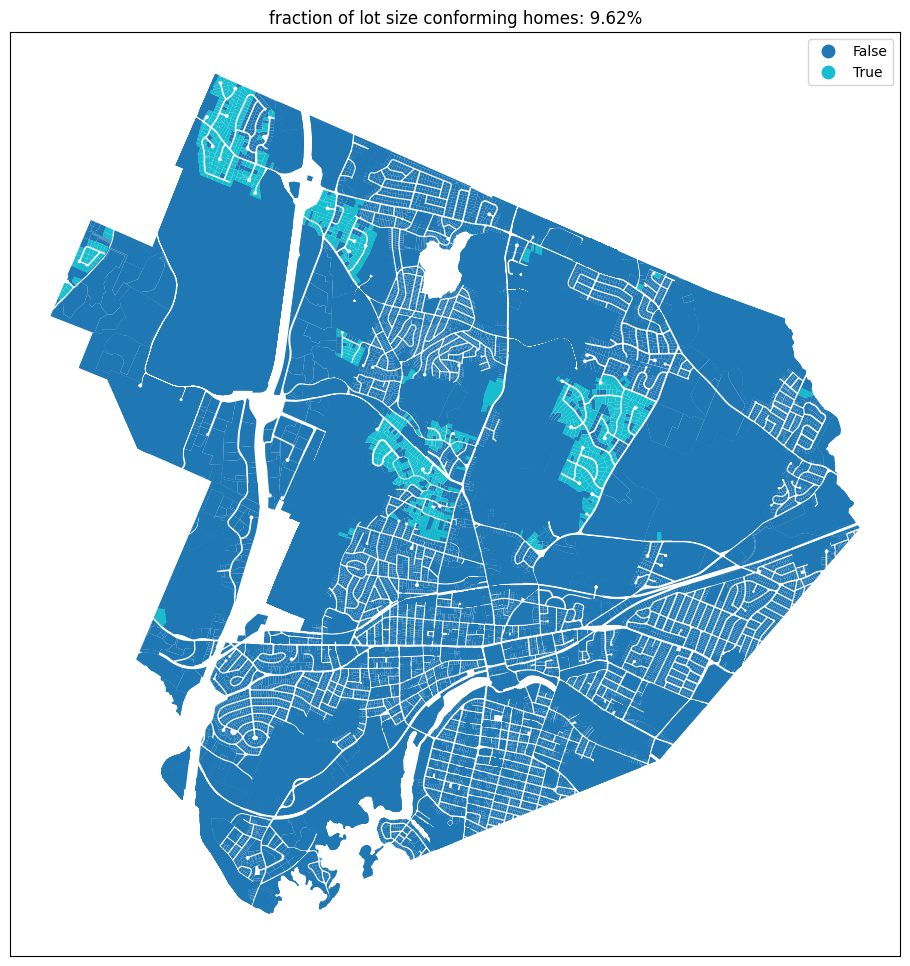

In [24]:
ax = df.plot(column="IS_LOT_SIZE_CONFORMING", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

num_conforming = len(df[df["IS_LOT_SIZE_CONFORMING"]])

ax.set_title(f"fraction of lot size conforming homes: {100 * num_conforming / valid_sfh_homes:.2f}%")

In [27]:
df.columns

Index(['geom', 'LOC_ID', 'NAME', 'PROP_ID', 'LOT_SIZE', 'USE_CODE',
       'SITE_ADDR', 'YEAR_BUILT', 'OWNER_OCCUPIED', 'IS_SFH',
       'IS_OWNER_OCCUPIED_SFH', 'IS_LOT_SIZE_CONFORMING'],
      dtype='object')

## (i)

_The building in which the proposed dwelling unit is to be located existed on the date of the adoption of this subsection._

This is quite prohibitive in my interpretation - it seems to suggest you can't build new structures and convert them to ADUs.

I think one might find this [here](https://ecode360.com/29869836) but it's not really clear when this section was added. It could be the 1988 renumbering of sections 
(which is listed as 'All' sections in this table), but it was probably added earlier and just not amended.

Fortunately, this was done at the end of 1988 so we just have to check outbuildings (I think only detached structures are permitted) built before 1989.

In [38]:
temp_df = principal_bldgs_df.merge(df[["LOC_ID", "YEAR_BUILT"]], on="LOC_ID")

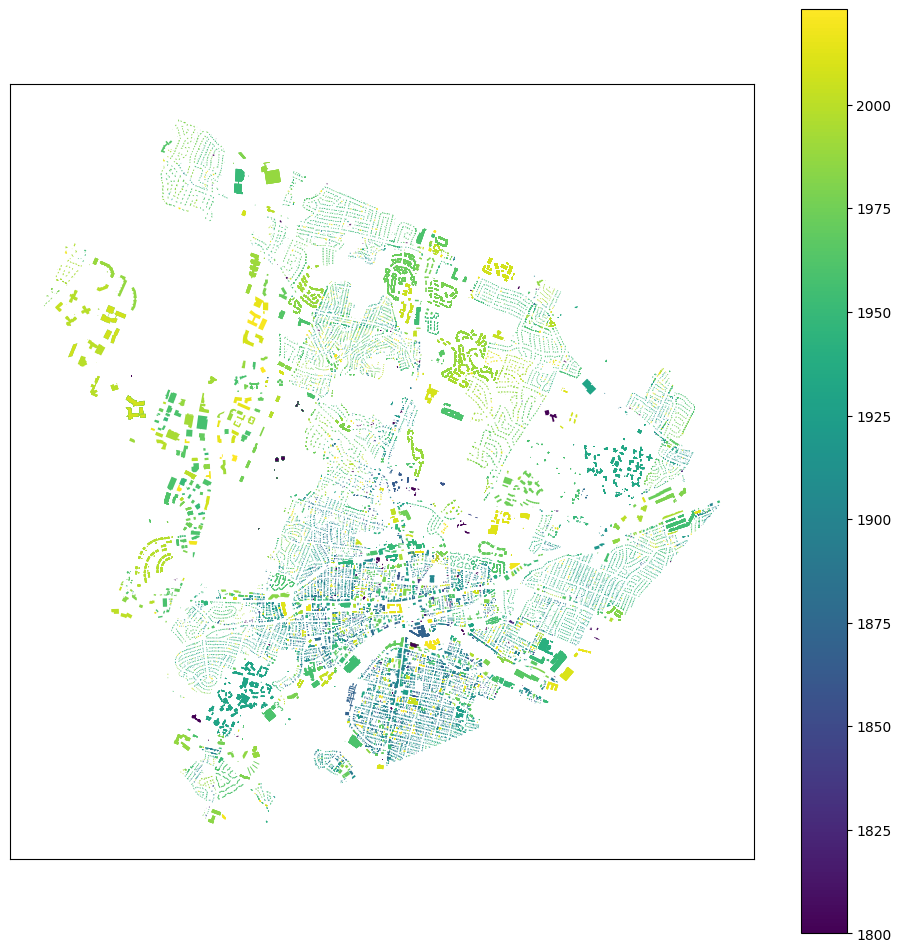

In [39]:
ax = temp_df.plot(column="YEAR_BUILT", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax

In [ ]:
# TODO:
# lots of questions here - are detached ADUs okay? what date do we refer to?

def is_preexisting_outbldg(row):
    if not row["IS_LOT_SIZE_CONFORMING"]:
        return False
    
    if row["YEAR_BUILT"] >= 1989:
        return False

    return True


temp["IS_PREXEXISTING_OUTBLDG"] = temp.apply(lambda row: is_preexisting_outbldg(row), axis=1)

In [ ]:
ax = temp.plot(column="IS_PREXEXISTING_OUTBLDG", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title(f"has a pre-existing out building: {len(temp[temp['IS_PREXEXISTING_OUTBLDG']])}")